<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/custom_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Parser - Simple

This tutorial uses the [Global Wheat Detection](http://www.global-wheat.com/) dataset, you can download it from Kaggle [here](https://www.kaggle.com/c/global-wheat-detection/data).

## Instaling icevision

!!! warning "Google Colab Dependencies Incompatibilities "
    This issue is specific to Google Colab. The issue shouldn't occur on a local machine.
    Some of our external dependencies are not aligned with the dependencies pre-installed in Google Colab. 
    After pip installing both icevision and icedata (by runnning the cell here below), some errors will eventually pop up.
    To fix this issue, press the **RESTART RUNTIME** button.

In [ ]:
!pip install icevision[all]

## Imports
As always, let's import everything from `icevision`. Additionally, we will also need `pandas` (you might need to install it with `pip install pandas`).

In [2]:
from icevision.all import *
import pandas as pd

## Understand the data format

In this task we were given a `.csv` file with annotations, let's take a look at that.

!!! danger "Important"  
    Replace `source` with your own path for the dataset directory.

In [2]:
source = Path("/home/lgvaz/data/wheat")
df = pd.read_csv(source / "train.csv")
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


At first glance, we can make the following assumptions:  

  * Multiple rows with the **same** object_id, width, height  
  * A **different** bbox for each row  
  * source doesn't seem relevant right now  
  
Once we know what our data provides we can create our custom `Parser`.  

## Create the Parser

When creating a `Parser` we inherit from smaller building blocks that provides the functionallity we want:  

  * `parsers.FasterRCNN`: Since we only need to predict bboxes we will use a `FasterRCNN` model, this will parse all the requirements for using such a model.  
  * `parsers.FilepathMixin`: Provides the requirements for parsing images filepaths.
  * `parsers.SizeMixin`: Provides the requirements for parsing the image dimensions.

The first step is to create a class that inherits from these smaller building blocks:

In [3]:
class WheatParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    pass

We now use a method `generate_template` that will print out all the necessary methods we have to implement.

In [4]:
WheatParser.generate_template()

def __iter__(self) -> Any:
def imageid(self, o) -> Hashable:
def image_width_height(self, o) -> Tuple[int, int]:
    return get_image_size(self.filepath(o))
def filepath(self, o) -> Union[str, Path]:
def bboxes(self, o) -> List[BBox]:
def labels(self, o) -> List[int]:


With this, we know what methods we have to implement and what each one should return (thanks to the type annotations)!  

Defining the `__init__` is completely up to you, normally we have to pass our data (the `df` in our case) and the folder where our images are contained (`source` in our case).

We then override `__iter__`, telling our parser how to iterate over our data. In our case we call `df.itertuples` to iterate over all `df` rows.

`__len__` is not obligatory but will help visualizing the progress when parsing.

And finally we override all the other methods, they all receive a single argument `o`, which is the object returned by `__iter__` (a single `DataFrame` row here).

!!! danger "Important"  
    Be sure to return the correct type on all overriden methods!

In [5]:
class WheatParser(parsers.FasterRCNN, parsers.FilepathMixin, parsers.SizeMixin):
    def __init__(self, df, source):
        self.df = df
        self.source = source

    def __iter__(self):
        yield from self.df.itertuples()

    def __len__(self):
        return len(self.df)

    def imageid(self, o) -> Hashable:
        return o.image_id

    def filepath(self, o) -> Union[str, Path]:
        return self.source / f"{o.image_id}.jpg"

    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(self.filepath(o))

    def labels(self, o) -> List[int]:
        return [1]

    def bboxes(self, o) -> List[BBox]:
        return [BBox.from_xywh(*np.fromstring(o.bbox[1:-1], sep=","))]

Let's randomly split the data and parser with `Parser.parse`:

In [7]:
parser = WheatParser(df, source / "train")
train_rs, valid_rs = parser.parse()

Let's take a look at one record:

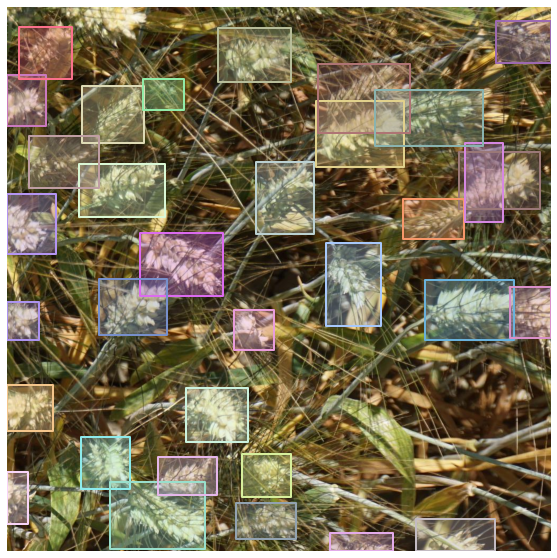

In [11]:
show_record(train_rs[0], label=False)

## Conclusion

And that's it! Now that you have your data in the standard library record format, you can use it to create a `Dataset`, visualize the image with the annotations and basically use all helper functions that IceVision provides! 

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).